# 第四讲 功能扩展

## 一、 回顾

### 1、tf.keras 搭建神经网络八股——六步法

### 2、代码 mnist_train_baseline.py

In [ ]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), validation_freq=1)
model.summary()

## 二、本讲用 tf.keras 完善功能模块

### 1、自制数据集，应对特定应用

#### 1.1、观察数据集数据结构，配成特征标签对

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os

train_path = "./MNIST_FC/mnist_image_label/mnist_train_jpg_60000/"
train_txt = "./MNIST_FC/mnist_image_label/mnist_train_jpg_60000.txt"
x_train_save_path = "./MNIST_FC/mnist_image_label/mnist_x_train.npy"
y_train_save_path = "./MNIST_FC/mnist_image_label/mnist_y_train.npy"


test_path = "./MNIST_FC/mnist_image_label/mnist_test_jpg_10000/"
test_txt = "./MNIST_FC/mnist_image_label/mnist_test_jpg_10000.txt"
x_test_save_path = "./MNIST_FC/mnist_image_label/mnist_x_test.npy"
y_test_save_path = "./MNIST_FC/mnist_image_label/mnist_y_test.npy"

def generateds(path, txt):
    f = open(txt, 'r') #以只读形式打开txt文件
    contents = f.readlines() # 读取文件中所有行
    f.close() # 关闭文件
    x, y_ = [], []
    for content in contents: #逐行取出
        value = content.split() # 以空格分，开图片路径为value[0] , 标签为value[1] , 存入列表
        img_path = path + value[0] #拼出图片路径和文件名
        img = Image.open(img_path) # 读入图片
        img = np.array(img.convert('L'))  # 图片变为8位宽灰度值的np.array格式
        img = img/ 255.  # 数据归一化 （实现预处理）
        x.append(img)  # 归一化后的数据，贴到列表x
        y_.append(value[1]) # 标签贴到列表y_
        # print('loading :' + content)  # 打印状态提示
    x = np.array(x) # 变为np.array格式
    y_ = np.array(y_) # 变为np.array格式
    y_ = y_.astype(np.int64) # 变为64位整型
    return x, y_


if (os.path.exists(x_train_save_path)
    and os.path.exists(y_train_save_path) 
    and os.path.exists(x_test_save_path) 
    and os.path.exists(y_test_save_path)):
    
    print('-------------Load Datesets-------------------------')
    x_train_save = np.load(x_train_save_path)
    y_train_save = np.load(y_train_save_path)
    x_test_save = np.load(x_test_save_path)
    y_test_save = np.load(y_test_save_path)
    x_train= np.reshape(x_train_save, (len(x_train_save), 28, 28))
    x_test = np.reshape(x_test_save, (len(x_test_save), 28, 28))
else:
    print('------------Generate Data sets-------------------')
    x_train, y_train = generateds(train_path, train_txt)
    x_test, y_test = generateds(test_path, test_txt) 
    
    print('-------------Save Datasets-----------------')
    x_train_save = np.reshape(x_train, (len(x_train), -1)) 
    x_test_save = np.reshape(x_test, (len(x_test), -1))
    np.save(x_train_save_path, x_train_save)
    np.save(y_train_save_path, y_train)
    np.save(x_test_save_path, x_test_save)
    np.save(y_test_save_path, y_test)
    
    
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), validation_freq=1)
model.summary()

### 2、数据增强，增大数据量

xtrain (60000, 28, 28, 1)
x_train_subset1 (12, 28, 28)
xtrain (60000, 28, 28, 1)
x_train_subset2 (12, 28, 28, 1)


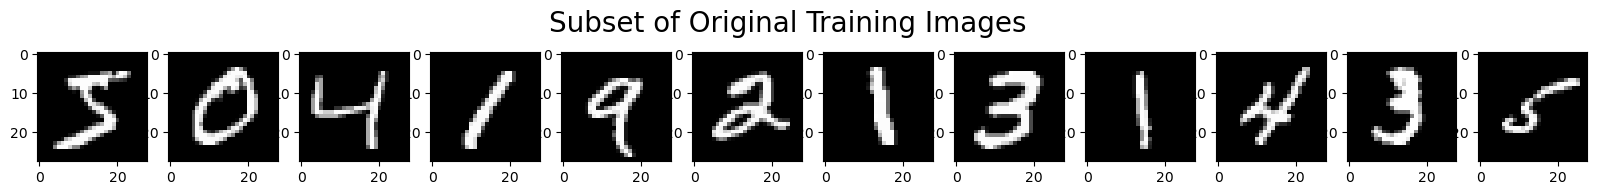

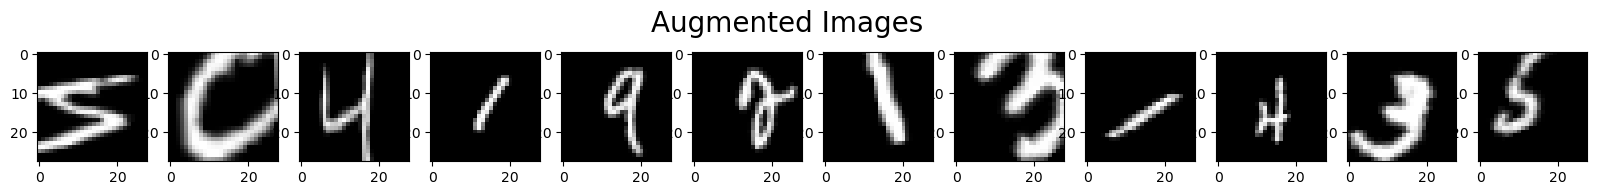

In [6]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) # 给数据增加一个维度，使数据和网络结构匹配
x_test= x_test.reshape(x_test.shape[0], 28, 28, 1)

image_gen_train = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=False,
    zoom_range=0.5 
)

image_gen_train.fit(x_train)
print("xtrain", x_train.shape)
x_train_subset1 = np.squeeze(x_train[:12])
print("x_train_subset1",x_train_subset1.shape)
print("xtrain", x_train.shape)
x_train_subset2 = x_train[:12] # 一次显示12张图片
print("x_train_subset2",x_train_subset2.shape)

fig = plt.figure(figsize=(20, 2))
plt.set_cmap('gray')
# 显示原始图片
for i in range(0, len(x_train_subset1)):
    ax = fig.add_subplot(1, 12, i + 1)
    ax.imshow(x_train_subset1[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# 显示增强后的图片
for x_batch in image_gen_train.flow(x_train_subset2, batch_size=12, shuffle=False):
    fig = plt.figure(figsize=(20, 2))
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i + 1)
        ax.imshow(np.squeeze(x_batch[i]))
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break

#### 2.1、数据增强（增大数据量）

#### 2.2、数据增强可视化 (代码 show_augmented _images.py)

### 3、断点续训，存取模型

#### 3.1、读取模型

#### 3.2、保存模型

### 4、参数提取，写至文本

#### 4.1、提取可训练参数

#### 4.2、设置 print 输出格式

### 5、acc/loss 可视化，查看效果

#### 5.1、acc 曲线与 loss 曲线

### 6、应用程序，给图识物

#### 6.1、给图识物

#### 6.2、前向传播执行应用

## 三、补充

### 1、数据集 Fashion_mnist